In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from datetime import datetime
import calendar
from math import sin, cos, sqrt, atan2, radians,asin
import folium
from folium import FeatureGroup, LayerControl, Map, Marker
from folium.plugins import HeatMap
from folium.plugins import TimestampedGeoJson
from folium.plugins import MarkerCluster
from geopy.distance import great_circle
import matplotlib.dates as mdates
import matplotlib as mpl
from datetime import timedelta
import datetime as dt
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
plt.style.use('fivethirtyeight')
import folium
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import pickle
from geopy.distance import geodesic

In [2]:
##the training data has 55M rows. In this kernel, we shall only read in 6M rows
train=pd.read_csv("train_cab.csv",nrows=6000000)
train.head()

fare_amount          pickup_datetime  pickup_longitude  pickup_latitude  \
0  4.5          2009-06-15 17:26:21 UTC -73.844311         40.721319         
1  16.9         2010-01-05 16:52:16 UTC -74.016048         40.711303         
2  5.7          2011-08-18 00:35:00 UTC -73.982738         40.761270         
3  7.7          2012-04-21 04:30:42 UTC -73.987130         40.733143         
4  5.3          2010-03-09 07:51:00 UTC -73.968095         40.768008         

   dropoff_longitude  dropoff_latitude  passenger_count  
0 -73.841610          40.712278         1.0              
1 -73.979268          40.782004         1.0              
2 -73.991242          40.750562         2.0              
3 -73.991567          40.758092         1.0              
4 -73.956655          40.783762         1.0

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16065 entries, 0 to 16064
Data columns (total 7 columns):
fare_amount          16041 non-null float64
pickup_datetime      16065 non-null object
pickup_longitude     16065 non-null float64
pickup_latitude      16065 non-null float64
dropoff_longitude    16065 non-null float64
dropoff_latitude     16065 non-null float64
passenger_count      16010 non-null float64
dtypes: float64(6), object(1)
memory usage: 878.6+ KB


# Convert pickup_datetime from Object to Datetime object

In [4]:
train['pickup_datetime']=pd.to_datetime(train['pickup_datetime'],format='%Y-%m-%d %H:%M:%S UTC')
train.head()

fare_amount     pickup_datetime  pickup_longitude  pickup_latitude  \
0  4.5         2009-06-15 17:26:21 -73.844311         40.721319         
1  16.9        2010-01-05 16:52:16 -74.016048         40.711303         
2  5.7         2011-08-18 00:35:00 -73.982738         40.761270         
3  7.7         2012-04-21 04:30:42 -73.987130         40.733143         
4  5.3         2010-03-09 07:51:00 -73.968095         40.768008         

   dropoff_longitude  dropoff_latitude  passenger_count  
0 -73.841610          40.712278         1.0              
1 -73.979268          40.782004         1.0              
2 -73.991242          40.750562         2.0              
3 -73.991567          40.758092         1.0              
4 -73.956655          40.783762         1.0

# Create datetime features based on pickup_datetime

In [5]:
train['pickup_date']= train['pickup_datetime'].dt.date
train['pickup_day']=train['pickup_datetime'].apply(lambda x:x.day)
train['pickup_hour']=train['pickup_datetime'].apply(lambda x:x.hour)
train['pickup_month']=train['pickup_datetime'].apply(lambda x:x.month)
train['pickup_year']=train['pickup_datetime'].apply(lambda x:x.year)

# Check for Missing Values

In [6]:
train[pd.isnull(train)].sum()

fare_amount          0.0
pickup_datetime      0.0
pickup_longitude     0.0
pickup_latitude      0.0
dropoff_longitude    0.0
dropoff_latitude     0.0
passenger_count      0.0
pickup_date          0.0
pickup_day           0.0
pickup_hour          0.0
pickup_month         0.0
pickup_year          0.0
dtype: float64

In [7]:
#There are no missing values in the data.

# Exploratory Data Analysis

Text(0.5, 1.0, 'Distribution of Trip Fare')

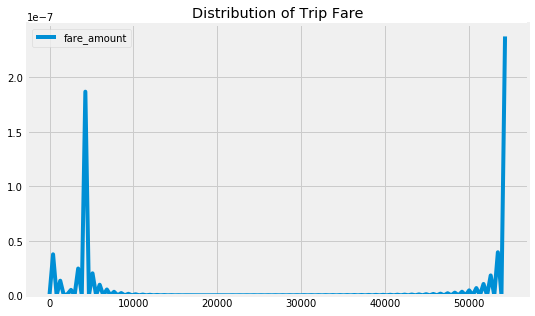

In [8]:
# ** Distribution of Trip Fare**
plt.figure(figsize=(8,5))
sns.kdeplot(train['fare_amount']).set_title("Distribution of Trip Fare")

In [9]:
# There are some negative fare amount in the data and also it is skewed. Let us have a look at these data points

In [10]:
train.loc[train['fare_amount']<0].shape

(3, 12)

In [11]:
# There are 262 records with negative fare. We will remove these records from the data

In [12]:
train=train.loc[train['fare_amount']>=0]
train.shape

(16038, 12)

In [13]:
# Since we saw above that fare amount is highly skewed,
#let us take log transformation of the fare amount and plot the distribution

Text(0.5, 1.0, 'Distribution of fare amount (log scale)')

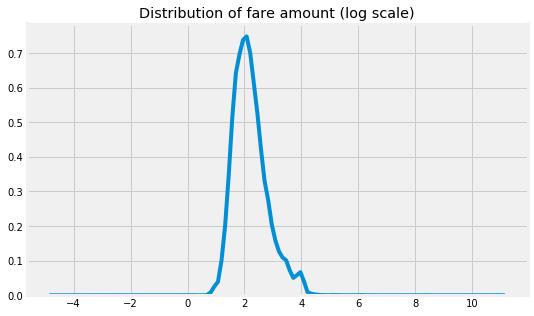

In [14]:
plt.figure(figsize=(8,5))
sns.kdeplot(np.log(train['fare_amount'].values)).set_title("Distribution of fare amount (log scale)")

In [15]:
# Most fares are between 2.7 and 54 dollars .Median fare is around $7

# Let us look at Geographical Features and their relationship with Fare Amount

## Distribution of Pickup and Dropoff Lat Lng

In [16]:
print("Range of Pickup Latitude is ", (min(train['pickup_latitude']),max(train['pickup_latitude'])))

Range of Pickup Latitude is  (-74.006893, 401.083332)


In [17]:
print("Range of Dropoff Latitude is ", (min(train['dropoff_latitude']),max(train['dropoff_longitude'])))

Range of Dropoff Latitude is  (-74.006377, 40.802437)


In [18]:
#The range of dropoff and pickup latitudes indicates lot of outlier locations in the train data.
#Before we  ahead and identify outlier location, let us read the test data and see what the boundaries are.
test =  pd.read_csv("test.csv")
print("Longitude Boundary in test data")
min(test.pickup_longitude.min(), test.dropoff_longitude.min()),max(test.pickup_longitude.max(), test.dropoff_longitude.max())

Longitude Boundary in test data


(-74.263242, -72.986532)

In [19]:
print("Latitude Boundary in test data")
min(test.pickup_latitude.min(), test.pickup_latitude.min()),max(test.pickup_latitude.max(), test.pickup_latitude.max())

Latitude Boundary in test data


(40.573143, 41.709555)

In [20]:
#Let us set the boundary for the train data also based on test data lat lng boundaries.
#We will mark the outlier locations as 1 and remove them for further analysis.
boundary={'min_lng':-74.263242,
              'min_lat':40.573143,
              'max_lng':-72.986532, 
              'max_lat':41.709555}

In [21]:
#There are a lot of cases where lat lng is zero. 
#Let us know how many such cases are there in the data.
train[(train.pickup_latitude==0) | (train.pickup_longitude)==0 | (train.dropoff_latitude==0)|(train.dropoff_longitude==0)].shape

(312, 12)

In [22]:
#Some records have either pickup/dropoff lat/lng as 0.0 . 
#There is a high chance this is present in test data as well. 
#So, let us create a field called is_outlier_loc and mark as 1 in case it is an outlier. Any point beyond border is an outlier. 
#We will also drop all rows where the pickup or dropoff location is an outlier

In [23]:
train.loc[~((train.pickup_longitude >= boundary['min_lng'] ) & (train.pickup_longitude <= boundary['max_lng']) &
            (train.pickup_latitude >= boundary['min_lat']) & (train.pickup_latitude <= boundary['max_lat']) &
            (train.dropoff_longitude >= boundary['min_lng']) & (train.dropoff_longitude <= boundary['max_lng']) &
            (train.dropoff_latitude >=boundary['min_lat']) & (train.dropoff_latitude <= boundary['max_lat'])),'is_outlier_loc']=1
train.loc[((train.pickup_longitude >= boundary['min_lng'] ) & (train.pickup_longitude <= boundary['max_lng']) &
            (train.pickup_latitude >= boundary['min_lat']) & (train.pickup_latitude <= boundary['max_lat']) &
            (train.dropoff_longitude >= boundary['min_lng']) & (train.dropoff_longitude <= boundary['max_lng']) &
            (train.dropoff_latitude >=boundary['min_lat']) & (train.dropoff_latitude <= boundary['max_lat'])),'is_outlier_loc']=0

print("Outlier vs Non Outlier Counts")
print(train['is_outlier_loc'].value_counts())

# Let us drop rows, where location is outlier
train=train.loc[train['is_outlier_loc']==0]
train.drop(['is_outlier_loc'],axis=1,inplace=True)

Outlier vs Non Outlier Counts
0.0    15686
1.0    352  
Name: is_outlier_loc, dtype: int64


In [24]:
#156K records are outliers

# Plot Heatmap of Pickups and Dropoffs within City

(-74.03, -73.75)

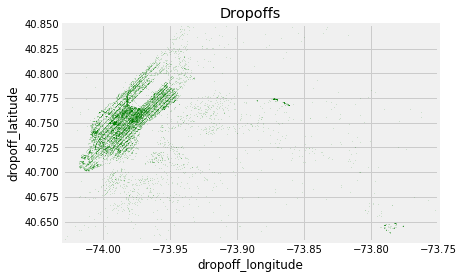

In [25]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

train.plot(kind='scatter', x='dropoff_longitude', y='dropoff_latitude',
                color='green', 
                s=.02, alpha=.6)
plt.title("Dropoffs")

plt.ylim(city_lat_border)
plt.xlim(city_long_border)

# Heatmap based on fare amount across City

In [26]:
# Let us round pickup and dropoff lat lng to 3 decimal places
train['pickup_latitude_round3']=train['pickup_latitude'].apply(lambda x:round(x,3))
train['pickup_longitude_round3']=train['pickup_longitude'].apply(lambda x:round(x,3))
train['dropoff_latitude_round3']=train['dropoff_latitude'].apply(lambda x:round(x,3))
train['dropoff_longitude_round3']=train['dropoff_longitude'].apply(lambda x:round(x,3))

In [27]:
pickup_fare_amount=train.groupby(['pickup_latitude_round3','pickup_longitude_round3'])['fare_amount'].mean().reset_index().rename(columns={'fare_amount':'avg_fare'})
pickup_fare_amount.head()

pickup_latitude_round3  pickup_longitude_round3  avg_fare
0  40.604                 -73.780                   5.5     
1  40.609                 -74.090                   7.7     
2  40.615                 -73.944                   5.5     
3  40.617                 -73.929                   12.5    
4  40.620                 -73.960                   8.5

In [28]:
#In the scatter plot, we saw the high density of pickups and dropoffs.
#Let us look at over time how fares are from any 3 areas of Cities say, A,B,C

In [29]:
A={'min_lng':-73.8352,
     'min_lat':40.6195,
     'max_lng':-73.7401, 
     'max_lat':40.6659}
A_center=[40.6437,-73.7900]
# Get all pickups to JFK
A_data=train.loc[(train.pickup_latitude>=A['min_lat']) & (train.pickup_latitude<=A['max_lat'])]
A_data=A_data.loc[(train.pickup_longitude>=A['min_lng']) & (train.pickup_longitude<=A['max_lng'])]

print("Number of Trips with Pickups from A",A_data.shape[0])

A_dropoff=train.loc[(train.dropoff_latitude>=A['min_lat']) & (train.dropoff_latitude<=A['max_lat'])]
A_dropoff=A_dropoff.loc[(train.dropoff_longitude>=A['min_lng']) & (train.dropoff_longitude<=A['max_lng'])]

print("Number of Trips with Dropoffs to A",A_dropoff.shape[0])


# Create a folium map with A as the center 
m=folium.Map(location =A_center,zoom_start = 10,)
folium.Marker(location=A_center, popup='A Airport',icon=folium.Icon(color='black')).add_to(m)

#mc = MarkerCluster().add_to(m)
#Add markers in blue for each pickup location and line between A and Pickup location over time. The thickness of line indicates the fare_amount

for index,row in A_data.iterrows():
    folium.Marker([row['dropoff_latitude'],row['dropoff_longitude']]).add_to(m)


    

Number of Trips with Pickups from A 244
Number of Trips with Dropoffs to A 118


Text(0.5, 1.0, 'Fare Amount Distribution')

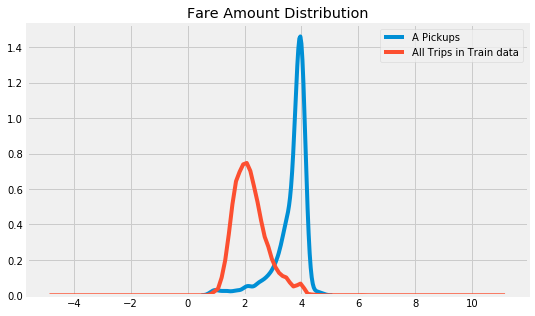

In [30]:
# Let us calculate the Average Fare amount of trips from A
plt.figure(figsize=(8,5))
sns.kdeplot(np.log(A_data['fare_amount'].values),label='A Pickups')
#sns.kdeplot(np.log(A_dropoff['fare_amount'].values),label='A Dropoff')
sns.kdeplot(np.log(train['fare_amount'].values),label='All Trips in Train data')
plt.title("Fare Amount Distribution")

In [31]:
#As we can see, the fare amount is much higher when pickup is from A.

Text(0.5, 1.0, 'Dropoffs vs Fare Amount')

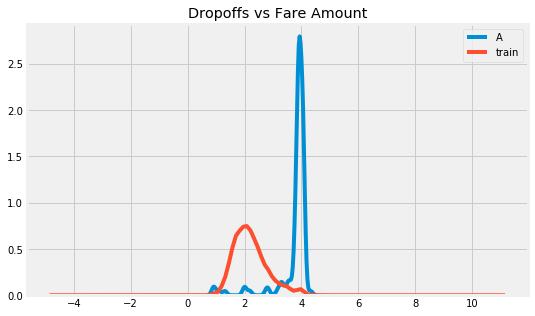

In [32]:
plt.figure(figsize=(8,5))
sns.kdeplot(np.log(A_dropoff['fare_amount'].values),label='A')
sns.kdeplot(np.log(train['fare_amount'].values),label='train')
plt.title("Dropoffs vs Fare Amount")

In [33]:
del A_data
del A
del A_dropoff

In [34]:
#Distribution of fare amount for both pickup and dropoff to A is similar

In [35]:
## Based on the above, let us create a function to see whether pickup or dropoff is an Airport. 

def isAirport(latitude,longitude,airport_name='A'):
    if airport_name=='A':
        boundary={'min_lng':-73.8352,
     'min_lat':40.6195,
     'max_lng':-73.7401, 
     'max_lat':40.6659}
    elif airport_name=='B':
        boundary={
            'min_lng':-74.1925,
            'min_lat':40.6700, 
            'max_lng':-74.1531, 
            'max_lat':40.7081

        }
    elif airport_name=='C':
        boundary={'min_lng':-73.8895, 
                  'min_lat':40.7664, 
                  'max_lng':-73.8550, 
                  'max_lat':40.7931
                 }
    if latitude>=boundary['min_lat'] and latitude<=boundary['max_lat']:
        if longitude>=boundary['min_lng'] and longitude<=boundary['max_lng']:
            return 1
    else:
        return 0
        

nyc_airports={'A':{'min_lng':-73.8352,
     'min_lat':40.6195,
     'max_lng':-73.7401, 
     'max_lat':40.6659},
              
    'B':{'min_lng':-74.1925,
            'min_lat':40.6700, 
            'max_lng':-74.1531, 
            'max_lat':40.7081

        },
    'C':{'min_lng':-73.8895, 
                  'min_lat':40.7664, 
                  'max_lng':-73.8550, 
                  'max_lat':40.7931
        
    }
    
}
def isAirport(latitude,longitude,airport_name='A'):
    
    if latitude>=nyc_airports[airport_name]['min_lat'] and latitude<=nyc_airports[airport_name]['max_lat'] and longitude>=nyc_airports[airport_name]['min_lng'] and longitude<=nyc_airports[airport_name]['max_lng']:
        return 1
    else:
        return 0
        


In [36]:
train['is_pickup_A']=train.apply(lambda row:isAirport(row['pickup_latitude'],row['pickup_longitude'],'A'),axis=1)
train['is_dropoff_A']=train.apply(lambda row:isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'A'),axis=1)

In [37]:
train['is_pickup_B']=train.apply(lambda row:isAirport(row['pickup_latitude'],row['pickup_longitude'],'B'),axis=1)
train['is_dropoff_B']=train.apply(lambda row:isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'B'),axis=1)

In [38]:
train['is_pickup_C']=train.apply(lambda row:isAirport(row['pickup_latitude'],row['pickup_longitude'],'C'),axis=1)
train['is_dropoff_C']=train.apply(lambda row:isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'C'),axis=1)

### Trip Distance

In [39]:
#calculate trip distance in miles
def distance(lat1, lat2, lon1,lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a))

In [40]:
train['trip_distance']=train.apply(lambda row:distance(row['pickup_latitude'],row['dropoff_latitude'],row['pickup_longitude'],row['dropoff_longitude']),axis=1)

Text(0.5, 1.0, 'Distribution of Trip Distance (log scale)')

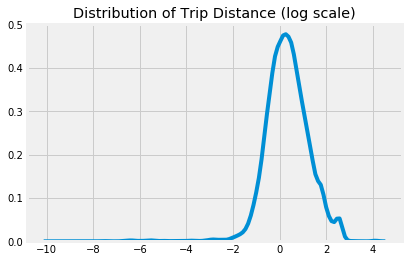

In [41]:
sns.kdeplot(np.log(train['trip_distance'].values)).set_title("Distribution of Trip Distance (log scale)")

Text(0.5, 1.0, 'Trip Distance vs Fare Amount')

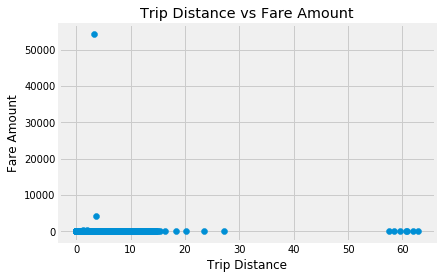

In [42]:
plt.scatter(x=train['trip_distance'],y=train['fare_amount'])
plt.xlabel("Trip Distance")
plt.ylabel("Fare Amount")
plt.title("Trip Distance vs Fare Amount")

In [43]:
#The fare seems to be fixed for trip distances > 50 miles. Normally airports pickup or dropoff have fixed prices. 
#We can remove the airport pickup and dropoff and plot the distribution of Fare Amount vs Trip distribution 

In [44]:
non_airport=train.loc[(train['is_dropoff_A']==0) & (train['is_dropoff_B']==0) & (train['is_dropoff_C']==0)]
non_airport=non_airport.loc[(non_airport['is_pickup_A']==0) & (non_airport['is_pickup_B']==0) & (non_airport['is_pickup_C']==0)]
non_airport.shape

(14794, 23)

Text(0.5, 1.0, 'Trip Distance vs Fare Amount (excluding airport rides)')

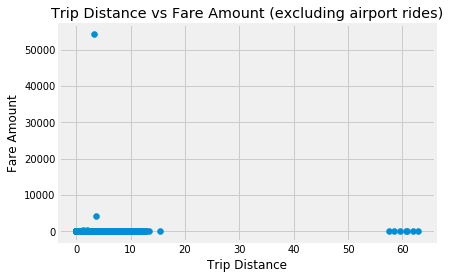

In [45]:
plt.scatter(x=non_airport['trip_distance'],y=non_airport['fare_amount'])
plt.xlabel("Trip Distance")
plt.ylabel("Fare Amount")
plt.title("Trip Distance vs Fare Amount (excluding airport rides)")

In [46]:
#In the plot above, we can see two clusters with linear realtionship between taxi fare and distance. 
#But for trip distances >50miles, though a linear relationship exists,the fare amount is very low. 
#Let us check where these trips originate and end

In [47]:
non_airport_long_trips=non_airport[non_airport['trip_distance']>=50]

In [48]:
drop_map = folium.Map(location = [40.730610,-73.935242],zoom_start = 12,)
#print(pickup.shape)
### For each pickup point add a circlemarker

for index, row in non_airport_long_trips.iterrows():
    
    folium.CircleMarker([row['dropoff_latitude_round3'], row['dropoff_longitude_round3']],
                        radius=3,
                        
                        color="#008000", 
                        fill_opacity=0.9
                       ).add_to(drop_map)
for index, row in non_airport_long_trips.iterrows():
    
    folium.CircleMarker([row['pickup_latitude_round3'], row['pickup_longitude_round3']],
                        radius=3,
                        
                        color="blue", 
                        fill_opacity=0.9
                       ).add_to(drop_map)

'''
hm_wide = HeatMap( list(zip(drop.dropoff_latitude_round3.values, drop.dropoff_longitude_round3.values, drop.Num_Trips.values)),
                     min_opacity=0.2,
                     radius=5, blur=15,
                     max_zoom=1 
                 )
drop_map.add_child(hm_wide)

'''

drop_map

### How does Number of passengers affect Fare time

In [49]:
#The fare is very high when there were 9 passengers. - only 2 records
#the number 129 and 208 passengers are surely outliers - three such records
#There are no records in test data where number of passengers is greater than 8 - so we will remove from train data records where number of passengers >8


In [50]:
def groupandplot(data,groupby_key,value,aggregate='mean'):
    plt.figure(figsize=(16,10))
    agg_data=data.groupby([groupby_key])[value].agg(aggregate).reset_index().rename(columns={value:aggregate+'_'+value})
    plt.subplot(1,2,1)
    count_data=train.groupby([groupby_key]).count()
    sns.barplot(x=groupby_key,y='Num_Trips',data=count_data).set_title("Number of Trips vs "+groupby_key)
    
    plt.subplot(1,2,2)
    sns.barplot(x=groupby_key,y=aggregate+'_'+value,data=agg_data).set_title(aggregate+'_'+value+" vs "+groupby_key)


In [51]:
print("Avg trip distance (in miles) when there are zero passengers",np.mean(train.loc[train['passenger_count']==0,'trip_distance'].values))

Avg trip distance (in miles) when there are zero passengers 1.7889220883872858


In [52]:
train=train[train['passenger_count']<=8]

In [53]:
# if there are 7 passengers, fare amount is lower. Fare amount is higher for 6 passengers**

In [54]:
train.to_csv("train_cleaned.csv",index=False)

In [56]:


test =  pd.read_csv("test.csv")
test['pickup_datetime']=pd.to_datetime(test['pickup_datetime'],format='%Y-%m-%d %H:%M:%S UTC')

test['pickup_date']= test['pickup_datetime'].dt.date
test['pickup_day']=test['pickup_datetime'].apply(lambda x:x.day)
test['pickup_hour']=test['pickup_datetime'].apply(lambda x:x.hour)
test['pickup_day_of_week']=test['pickup_datetime'].apply(lambda x:calendar.day_name[x.weekday()])
test['pickup_month']=test['pickup_datetime'].apply(lambda x:x.month)
test['pickup_year']=test['pickup_datetime'].apply(lambda x:x.year)
test['is_pickup_A']=test.apply(lambda row:isAirport(row['pickup_latitude'],row['pickup_longitude'],'A'),axis=1)
test['is_dropoff_A']=test.apply(lambda row:isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'A'),axis=1)
test['is_pickup_B']=test.apply(lambda row:isAirport(row['pickup_latitude'],row['pickup_longitude'],'B'),axis=1)
test['is_dropoff_B']=test.apply(lambda row:isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'B'),axis=1)
test['is_pickup_C']=test.apply(lambda row:isAirport(row['pickup_latitude'],row['pickup_longitude'],'C'),axis=1)
test['is_dropoff_C']=test.apply(lambda row:isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'C'),axis=1)
test['pickup_latitude_round3']=test['pickup_latitude'].apply(lambda x:round(x,3))
test['pickup_longitude_round3']=test['pickup_longitude'].apply(lambda x:round(x,3))
test['dropoff_latitude_round3']=test['dropoff_latitude'].apply(lambda x:round(x,3))
test['dropoff_longitude_round3']=test['dropoff_longitude'].apply(lambda x:round(x,3))
test['trip_distance']=test.apply(lambda row:distance(row['pickup_latitude'],row['dropoff_latitude'],row['pickup_longitude'],row['dropoff_longitude']),axis=1)



test.to_csv("test_cleaned.csv",index=False)